In [1]:
import numpy as np
import keras
import cv2
from keras import backend as k
from keras.models import Sequential,Model,load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose,AveragePooling2D, Concatenate
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
from google.colab import drive
drive.mount('/content/drive')

from PIL import Image
from skimage import color, io
from zipfile import ZipFile 
from io import BytesIO
import matplotlib.pyplot as plt

np.random.seed(1)
set_random_seed(1)

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  
  def __init__(self, list_IDs, zip_file, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.zip_file = zip_file
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.on_epoch_end()            # shuffle data on the beginning

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
    X = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      img_rgb = np.array(Image.open(BytesIO(self.zip_file.read(ID))).convert('RGB')) / 255
      img_lab = color.rgb2lab(img_rgb)
      img_lab[:,:,0] = img_lab[:,:,0] / 50 - 1
      img_lab[:,:,0] = img_lab[:,:,0]

      img_lab[:,:,1:] = (img_lab[:,:,1:] + 128) / 255 * 2 - 1
      
      y[i,] = img_lab
      X[i,] = color.rgb2gray(img_rgb)[...,np.newaxis]*2 - 1
            
    return X, y


In [0]:
data_path = '/content/drive/My Drive/data_b7b_elcima/colored.zip'
zip_data =  ZipFile(data_path, 'r')
ids = zip_data.namelist()[1:]
np.random.shuffle(ids)
dev_length = int(0.1 * len(ids))
test_length = int(0.05 * len(ids))
test_ids = ids[:test_length]
dev_ids = ids[test_length:dev_length]
train_ids = ids[dev_length:]

In [5]:
Input_train=Input((256,256,1))

#encoder part
c1=Conv2D(64,(4,4),padding='same',strides=(1,1),name='conv1')(Input_train)
c1=BatchNormalization()(c1)
c1=LeakyReLU(alpha=0.2)(c1)
c2=Conv2D(64,(4,4),padding='same',strides=(2,2),name='conv2')(c1)
c2=BatchNormalization()(c2)
c2=LeakyReLU(alpha=0.2)(c2)
c3=Conv2D(128,(4,4),padding='same',strides=(2,2),name='conv3')(c2)
c3=BatchNormalization()(c3)
c3=LeakyReLU(alpha=0.2)(c3)
c4=Conv2D(256,(4,4),padding='same',strides=(2,2),name='conv4')(c3)
c4=BatchNormalization()(c4)
c4=LeakyReLU(alpha=0.2)(c4)
c5=Conv2D(512,(4,4),padding='same',strides=(2,2),name='conv5')(c4)
c5=BatchNormalization()(c5)
c5=LeakyReLU(alpha=0.2)(c5)
c6=Conv2D(512,(4,4),padding='same',strides=(2,2),name='conv6')(c5)
c6=BatchNormalization()(c6)
c6=LeakyReLU(alpha=0.2)(c6)
c7=Conv2D(512,(4,4),padding='same',strides=(2,2),name='conv7')(c6)
c7=BatchNormalization()(c7)
c7=LeakyReLU(alpha=0.2)(c7)
c8=Conv2D(512,(4,4),padding='same',strides=(2,2),name='conv8')(c7)
c8=BatchNormalization()(c8)
c8=LeakyReLU(alpha=0.2)(c8)

#decoder part
d1=Conv2DTranspose(512,(4,4),padding='same',strides=(2,2),name='deconv1')(c8)
d1 = concatenate([d1, c7])
d1=BatchNormalization()(d1)
d1=Activation("relu")(d1)
d2=Conv2DTranspose(512,(4,4),padding='same',strides=(2,2),name='deconv2')(d1)
d2 = concatenate([d2, c6])
d2=BatchNormalization()(d2)
d2=Activation("relu")(d2)
d3=Conv2DTranspose(512,(4,4),padding='same',strides=(2,2),name='deconv3')(d2)
d3 = concatenate([d3, c5])
d3=BatchNormalization()(d3)
d3=Activation("relu")(d3)
d4=Conv2DTranspose(256,(4,4),padding='same',strides=(2,2),name='deconv4')(d3)
d4 = concatenate([d4, c4])
d4=BatchNormalization()(d4)
d4=Activation("relu")(d4)
d5=Conv2DTranspose(128,(4,4),padding='same',strides=(2,2),name='deconv5')(d4)
d5 = concatenate([d5, c3])
d5=BatchNormalization()(d5)
d5=Activation("relu")(d5)
d6=Conv2DTranspose(64,(4,4),padding='same',strides=(2,2),name='deconv6')(d5)
d6 = concatenate([d6, c2])
d6=BatchNormalization()(d6)
d6=Activation("relu")(d6)
d7=Conv2DTranspose(64,(4,4),padding='same',strides=(2,2),name='deconv7')(d6)
d7 = concatenate([d7, c1])
d7=BatchNormalization()(d7)
d7=Activation("relu")(d7)
#last layer
last_layer=Conv2D(3,(4,4),padding='same',strides=(1,1),activation='tanh',name='last_layer')(d7)
model = Model(inputs=[Input_train], outputs=[last_layer])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1088        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
_____________________________________

In [0]:
epochs = 10
batch_size = 32

training_generator = DataGenerator(train_ids, zip_data, batch_size=batch_size)
validation_generator = DataGenerator(dev_ids, zip_data, batch_size=batch_size)

In [0]:
# compile our model
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath = '/content/drive/My Drive/data_b7b_elcima/movieColor_{epoch:02d}-{val_loss:.2f}.hdf5')
callbacks_list = [checkpoint]
# training our model
model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs = epochs, callbacks=callbacks_list, verbose=1)
model.save("/content/drive/My Drive/movieColor.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1874/1874 [==============================] - 2950s 2s/step - loss: 0.0107 - acc: 0.6129 - val_loss: 0.0080 - val_acc: 0.6334
Epoch 2/10
 448/1874 [======>.......................] - ETA: 34:05 - loss: 0.0084 - acc: 0.6191

In [0]:
model = load_model('/content/drive/My Drive/data_b7b_elcima/movieColor_06-0.00.hdf5')
checkpoint = ModelCheckpoint(filepath = '/content/drive/My Drive/data_b7b_elcima/movieColor_{epoch:02d}-{val_acc:.2f}.hdf5')
callbacks_list = [checkpoint]
# training our model
model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs = epochs, callbacks=callbacks_list, verbose=1)
model.save('/content/drive/My Drive/data_b7b_elcima/movieColor_{epoch:02d}-{val_acc:.2f}.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1874/1874 [==============================] - 2927s 2s/step - loss: 0.0011 - acc: 0.8291 - val_loss: 0.0022 - val_acc: 0.7842
Epoch 2/10
1874/1874 [==============================] - 2840s 2s/step - loss: 0.0010 - acc: 0.8320 - val_loss: 0.0022 - val_acc: 0.7835
Epoch 3/10
1874/1874 [==============================] - 2830s 2s/step - loss: 9.5343e-04 - acc: 0.8357 - val_loss: 0.0022 - val_acc: 0.7835
Epoch 4/10
 287/1874 [===>..........................] - ETA: 38:15 - loss: 9.1963e-04 - acc: 0.8382

In [0]:
def lab_to_rgb(l_layer, ab_layers, img_size):
    new_img = np.zeros((img_size,img_size,2))
    rescaled_l = np.zeros((img_size,img_size,1))
    for i in range(len(ab_layers)):
        for j in range(len(ab_layers[i])):
            p = ab_layers[i,j]
            new_img[i,j] = [(p[0] +1) / 2 * 255 - 128, (p[1] +1) / 2 * 255 - 128]
            rescaled_l[i,j] = [(l_layer[i,j] + 1) * 50]

    # print(rescaled_l.shape)
    # print(new_img.shape)
    new_img = np.concatenate((rescaled_l,new_img),axis=-1)
    new_img = color.lab2rgb(new_img) * 255
    new_img = new_img.astype('uint8')
    return new_img

test_generator = DataGenerator(test_ids, zip_data)
x, y = test_generator[0]
output = model.predict(x[:2])
new_img = lab_to_rgb(x[0], output[0], 256)

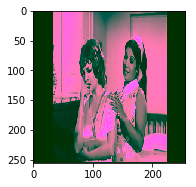

In [0]:
#plt.plt.figure(fig)
plt.subplot(1, 2, 1); plt.imshow(new_img)
#plt.subplot(1, 2, 2); plt.imshow(y[0])